<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/for-ideas/Feature_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Часть 0**
**Предобработка данных: формирование обучающей выборки и вектора признаков.**



# Загрузка изображений

Подключим гугл-диск и из соответствующей папки загрузим необходимые данные. Хранить изображения (PIL Image) будем в словаре, ключом в котором будет имя файла.

In [1]:
import os
import zipfile
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from google.colab import drive
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

# сгрузим пути к данным в один массив
"""directories = ['/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_test.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_val.zip']"""

RANDOM_SEED=42
PATH = '/content/drive/My Drive/Курсач/files/'               
directories = ['/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# распакуем архивы из гугл диска
z = []
for zips in directories:
    z.append(zipfile.ZipFile(zips, 'r'))

for archives in z:
    archives.extractall()


#list_dir= ['WIDER_test/images', 'WIDER_train/images', 'WIDER_val/images']
list_dir = ['WIDER_train/images']

In [3]:
#загружаем все изображения и конвертируем их в ч/б 
def upload(directory):
  list_name = {}
  list_dirs = os.listdir(directory)
  list_dirs.sort()
  for cur_dir in list_dirs:
    list_file = os.listdir(os.path.join(directory, cur_dir))
    list_file.sort()
    for cur_file in list_file:
      #img = Image.open(os.path.join(directory, cur_dir, cur_file)).convert("L")
      img = Image.open(os.path.join(directory, cur_dir, cur_file))
      list_name[cur_file] = img
      if (len(list_name) == 6000):
        return list_name


train = upload(list_dir[0])
#test=upload(list_dir[1])
#val = upload(list_dir[2])
keys_list = list(train.keys())
print(keys_list[0])

0_Parade_Parade_0_1014.jpg


#Загрузка рамок  
  В данном блоке осуществляется загрузка рамок с лицами. Для этого будем построчно читать txt файл, и если мы прочитали рамку(-и), к которой(-ым) у нас есть изображение, то загрузим их.

> The format of txt ground truth.  
File name  
Number of bounding box  
x1, y1, w, h, blur, expression, illumination,   invalid, occlusion, pose  

В случае если на изображении лиц нет, на вход будут поданы такие строки:

```
File name  
0  
0 0 0 0 0 0 0 0 0 0 
```


In [5]:
# загрузим рамки

Rectangle = namedtuple('Rectangle', 'x y w h')
frames = {}  # словарь Rectangle

# открываем нужный файлик
with open(os.path.join(PATH, 'wider_face_train_bbx_gt.txt'), "r+") as file:
    for lines in file:
        # имя файла
        filename = lines.rstrip(' \n').split("/")[1]
        # число прямоугольников
        n = int(file.readline())
        rects = []
        # если прямоугольников нет, то в след.строке будет 0 0 0 0 0 0 0, это всё равно нужо как-то прочитать:)
        if n == 0:
            n += 1
        for elems in range(n):
            # для каждого прямоугольника загружаем все предложенные данные
            params = file.readline().rstrip(' \n').split(" ")
            params = params[:4]
            rects.append(Rectangle(int(params[0]), int(
                params[1]), int(params[2]), int(params[3])))
        # проверяем наличие нужного изображения в словаре изображений
        if filename in train:
            frames[filename] = rects

print(len(frames))
print(frames[keys_list[0]])

# Проверка данных
Данные загружены, рамочки с координатами тоже. А давайте убедимся, что загрузка прошла успешно и в рамочках действительно будут лица.

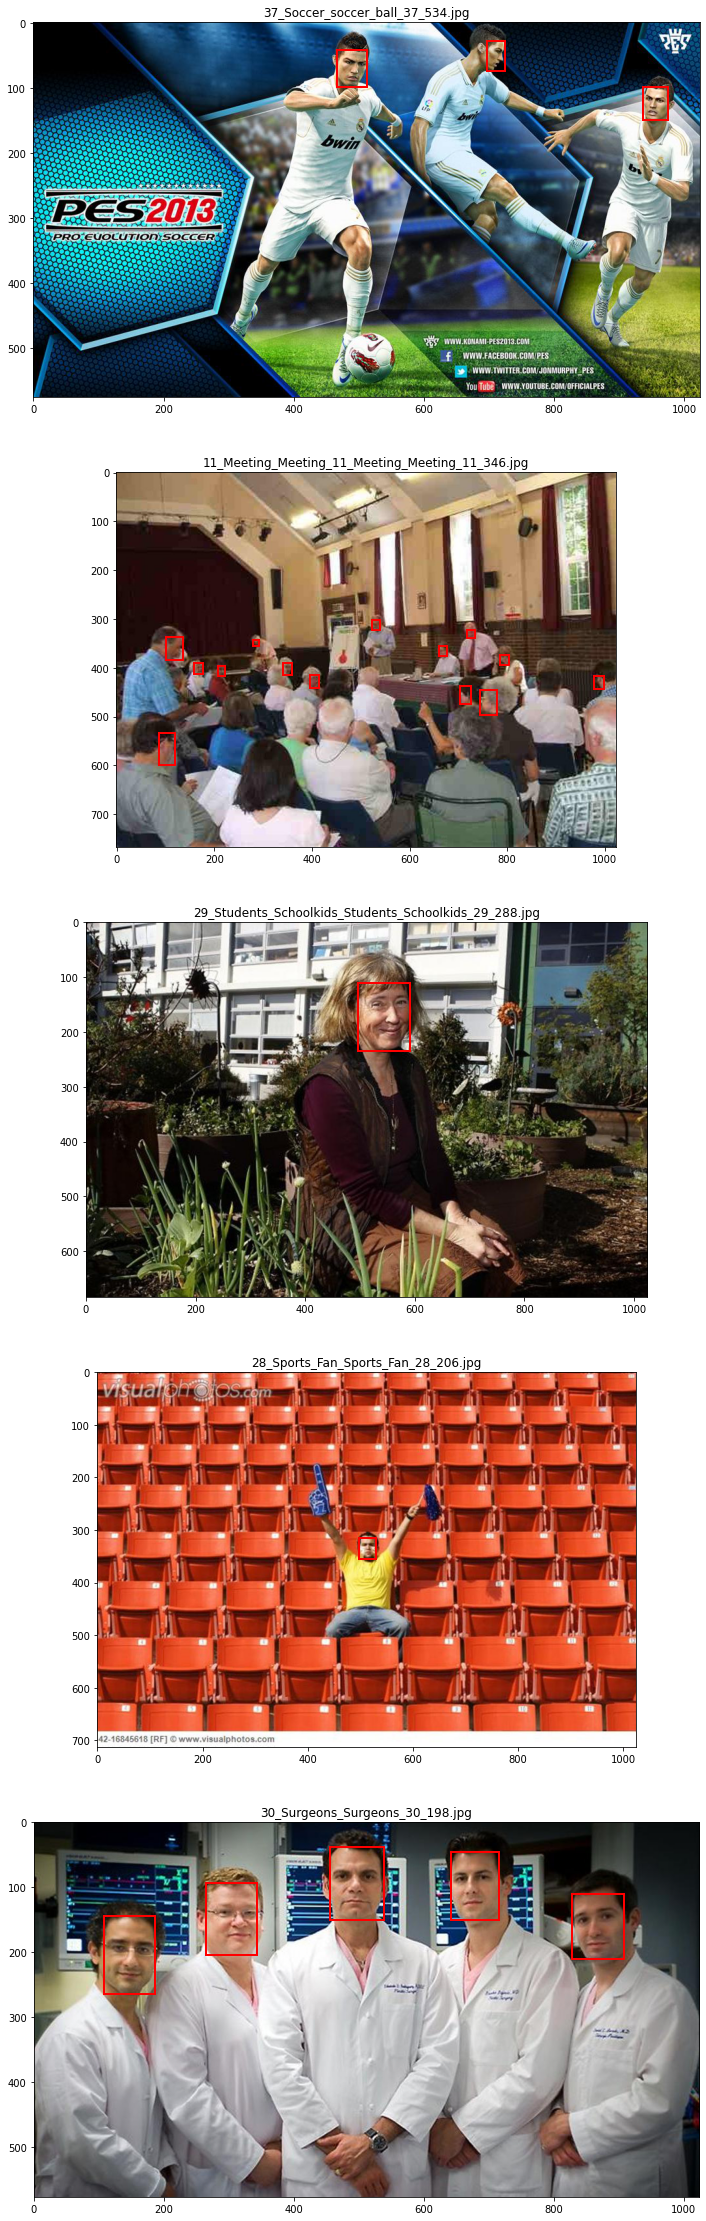

In [5]:
import matplotlib.patches as patches

fig = plt.figure(figsize = (30, 40))
COLUMNS = 1
ROWS = 5

# ax enables access to manipulate each of subplots
ax = []
np.random.seed(RANDOM_SEED)

for i in range(COLUMNS * ROWS):
    rand_num = np.random.randint(0, len(train))

    key = keys_list[rand_num]
    image = train[key]
    # create subplot and append to ax
    ax.append(fig.add_subplot(ROWS, COLUMNS, i + 1))
    for rect in frames[key]:
        rect = patches.Rectangle(
            (rect.x, rect.y), rect.w, rect.h, linewidth=2, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
    ax[-1].set_title(key)  # set title
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

plt.show()  # finally, render the plot

#Формируем новые выборки на основе наших изображений

Бежим циклом по всем изображениям из train и вырезаем все лица по следующему правилу:


*   Если лицо есть, то вырезаем его. В качестве не лица берём прямоугольник такого же размера, местоположение - по диагонали от лица, т.е у изображений есть общая точка
*   Если лица нет, то в качестве не лица берём рандомное место. В моём случае это (300, 300, 300, 300)  
  
  
Приведение в одному размеру было таким, чтобы ни один признак не вышел за этот размер.  
Изменение размера шло по принципу Image.LANCZOS. Гугл сказал, что он даёт самое лучшее качество при изменении изображения (вроде там основа от метода k-ближайших соседей)



---

Поскольку используемый xml-файл заточен под размер изображения 20 \* 20 пикселей, то растяжение изображения размера 3 \* 3 качество не улучшит. Поэтому изображения лиц, размеры которых меньше MINSIZE в обучающую выборку не попадут.   




In [4]:
# делаем новые выборки
import math

Faces = namedtuple('Faces', 'img is_face filename rect')
faces = []

MAXSIZE = (25, 25)
MINSIZE = (20, 20)
random_box = (30, 30, 30, 30)

for key in frames:
    for rect in frames[key]:
        if rect == (0, 0, 0, 0):
            img_not_face = train[key].crop(random_box).resize(MAXSIZE, Image.LANCZOS)
            faces.append(Faces(img_not_face, 0, key, Rectangle(random_box[0], random_box[1], random_box[2], random_box[3])))
        elif (rect.w, rect.h) < MINSIZE: 
            continue
        else:
            img_face = train[key].crop(
                (rect.x, rect.y, rect.x + rect.w, rect.y + rect.h)).resize(MAXSIZE, Image.LANCZOS)
            img_not_face = train[key].crop(
                (rect.x + rect.w, rect.y + rect.h, rect.x + 2 * rect.w, rect.y + 2 * rect.h)).resize(MAXSIZE, Image.LANCZOS)
            faces.append(Faces(img_face, 1, key, rect))
            faces.append(Faces(img_not_face, 0, key, Rectangle(rect.x + rect.w, rect.y + rect.h, rect.w, rect.h)))
    if len(faces) > 46000:
            break


print(faces[0])
print(len(faces))

# Демонстрация изображений 
Давайте посмотрим пару изображений из новой выборки

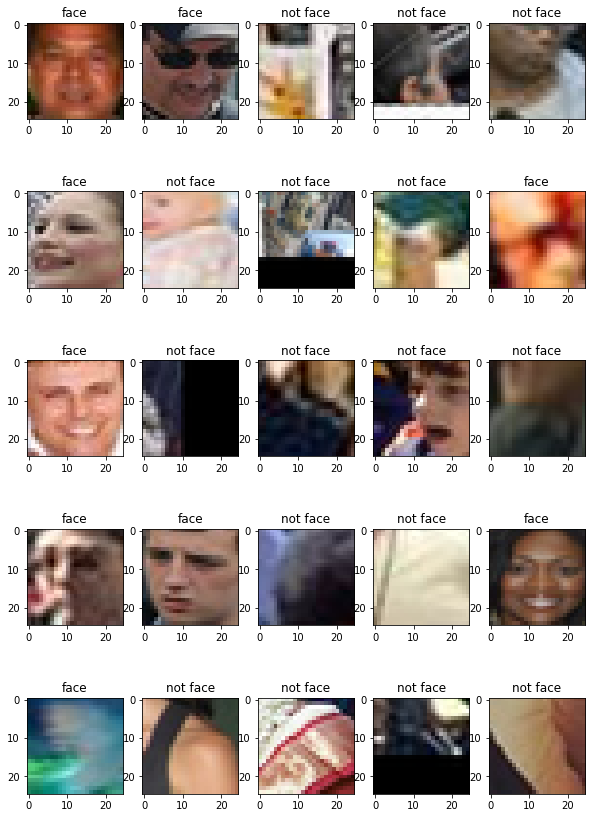

In [6]:
fig = plt.figure(figsize = (10, 15))
COLUMNS = 5
ROWS = 5

# ax enables access to manipulate each of subplots
ax = []
np.random.seed(RANDOM_SEED)

for i in range(COLUMNS * ROWS):
    rand_num = np.random.randint(0, len(faces))
    image = faces[rand_num].img
    # create subplot and append to ax
    ax.append(fig.add_subplot(ROWS, COLUMNS, i+1))
    if faces[rand_num].is_face == 1:
        ax[-1].set_title('face')  # set title
    else:
        ax[-1].set_title('not face')
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

plt.show()  # finally, render the plot

In [3]:
#cохраним цветные картинки, чтобы при вылете не делать всё заново
from sklearn.externals import joblib 
joblib.dump(faces, os.path.join(PATH,'color_faces.pkl'))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
#тут будем загружаться
faces = joblib.load(os.path.join(PATH,'color_faces.pkl'))

#Признаки Хоара

 Признаки я взяла из найденного раннее файла. Я скопировала n-строк, и там оказалось 109 признаков. 

 Формат хранения:
```
<features>  
  <_>
        <rects>
          <_>
            6 4 12 9 -1.</_>
          <_>
            6 7 12 3 3.</_></rects></_>
</features>
```
Представленный выше фрагмент описывает 1 признак Хоара, где прямоугольники задаются так:  
`<_> x1, y1, w, h, weight </_> `  
(верхний левый угол + ширина + высота + вес)  
  
более детальную информацию можно найти здесь:)  
https://api-2d3d-cad.com/viola-jones-method/

In [7]:
class HaarFeature:

    def __init__(self, rect_list):
        self.rect_list = rect_list

    def cacl_feature(self, cumsum_marix):
        f_X = 0
        for rects in self.rect_list:
            if ((rects.w, rects.h) >= MAXSIZE):
                continue
            else:
                f_X += (cumsum_marix[rects.y - 1 + rects.h][rects.x - 1 + rects.w]
                        - cumsum_marix[rects.y - 1][rects.x - 1 + rects.w]
                        - cumsum_marix[rects.y - 1 + rects.h][rects.x - 1]
                        + cumsum_marix[rects.y - 1][rects.x - 1])*rects.weight
        return f_X

In [8]:
# займёмся признаками Хоара
from lxml import etree

h_features = []
HaarRect = namedtuple('HaarRect', 'x y w h weight')

# загрузим xml и распарсим его
with open(os.path.join(PATH, 'my_features.xml')) as fobj:
    xml = fobj.read()
    root = etree.fromstring(xml)

    for elems in root.getchildren():
        for rects in elems.getchildren():
            rectangles = []
            for haar_rect in rects.getchildren():
                numbers = haar_rect.text[11:].split(" ")
                rectangles.append(HaarRect(int(numbers[0]), int(numbers[1]), int(
                    numbers[2]), int(numbers[3]), float(numbers[4])))

            h_features.append(HaarFeature(rectangles))
print(h_features[0].rect_list)

[HaarRect(x=6, y=4, w=12, h=9, weight=-1.0), HaarRect(x=6, y=7, w=12, h=3, weight=3.0)]


#Ищем фичи
В этом блоке формируется вектор признаков, который нам так нужен. Каким образом?  
Перемешаем наш массив картинок с лицами и без (на данный момент изображения идут примерно через один)
Далее бежим по новой выборке и для каждого изображения
переводим изображение в интегральное представление.

Один признак Хоара - это 2-3 прямоугольника. Я не знаю, стоит ли учитывать вес, тк в документации https://madebyollin.github.io/opencv-python-docs/#CascadeClassifier-detectMultiScale я нашла конструктор, который использую я. Но там нет ничего про вес. Однако есть конструктор с весами. Только вот я не поняла, там речь идёт про веса прямоугольников или про веса, так называемые sum_stage, которые являются значениями признаков и используются в каскадных классификаторах, чтобы проверять, прошли ли мы порог данного уровня или нет.  
Но при этом есть прямоугольники с положительными весами и с отрицательными, и я так понимаю, это что-то вроде градации на чёрное и белое (тк там где области накладываются, мы суммируем веса, а цвет опред.знаком). Если вес убрать, то нужно искать области, где прямоугольники накладываются друг на друга, поэтому я пока оставила всё с весами и просто суммирую все значения в рамках одного признака, умножив их на соответствующий вес.

In [9]:
# перемешаем выборку, подговим массив ответов, а также поделим всё на train  test
import sklearn.model_selection as sk

random.seed(RANDOM_SEED)
random.shuffle(faces)

y = np.array(list(map(lambda x: int(x.is_face), faces)))
x_train, x_test, y_train, y_test = sk.train_test_split(faces, y, test_size=0.25, random_state=0)


print(x_test[0])

Faces(img=<PIL.Image.Image image mode=RGB size=25x25 at 0x7F1BE76115C0>, is_face=0, filename='2_Demonstration_Political_Rally_2_300.jpg', rect=Rectangle(x=210, y=444, w=165, h=207))


In [10]:
# подготовим изображения для получения признаков на нём и посчитаем признаки
# формируем вектор признаков

def feature_creating(sample, feature_type):
    features = []
    
    for images in sample:
        img = np.array(images.img, 'uint8')
        if feature_type != 'hf':
            features.append(img.flatten())
        else:
            # интегральное представление изображения
            matrix = np.cumsum(np.cumsum(img, axis=0), axis=1)
            f_for_one_img = []
            for fichi in h_features:
               f_for_one_img.append(fichi.cacl_feature(matrix))
            features.append(f_for_one_img)
    return np.array(features)

In [20]:
#создаём признаки
import pandas as pd
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib 

samples = [x_train, x_test]
all_features = []

pca = PCA(n_components = len(h_features))
scaler = StandardScaler()

col_list = ['logreg_', 'tree_', 'knn_', 'svm_', 'randforest_', 'ada_boost_', 'grad_boost_']
categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']

time_df = pd.DataFrame(index = categories, columns = col_list)

for i, f_samples in enumerate(categories):
    parsed_str = f_samples.split("_")
    if  parsed_str[1] == 'train':
        index = 0
    else:
        index = 1
        
    t0 = time.time()
    all_features.append(feature_creating(samples[index], parsed_str[0]))
    t = time.time()
    time_df.loc[categories[i]] = (t - t0)/len(samples[index])

'''#сразу отмасштабируем полученные признаки
for i in range(0, len(all_features)//2 - 1):
    all_features[i] = scaler.fit_transform(all_features[i])
    all_features[i + 3] = scaler.transform(all_features[i + 3])
all_features[2] = pca.fit_transform(all_features[2])
all_features[5] = pca.transform(all_features[5])'''

#сохраним нашу выборку, она нам ещё понадобится
joblib.dump(all_features, os.path.join(PATH,'all_features_color.pkl'))
joblib.dump(y_train, os.path.join(PATH,'y_train_color.pkl'))
joblib.dump(y_test, os.path.join(PATH,'y_test_color.pkl'))
joblib.dump(x_train, os.path.join(PATH,'x_train_color.pkl'))
joblib.dump(x_test, os.path.join(PATH,'x_test_color.pkl'))
print(len(all_features[0]))

34505


In [ ]:
#время на создание фичей нам ещё пригодится, поэтому давайте пока сохраним куда-нибудь одну колонку
time_of_features_creat = time_df[col_list[0]].values.tolist()
joblib.dump(time_of_features_creat, os.path.join(PATH,'time_of_features_creat.pkl'))
joblib.dump(time_df, os.path.join(PATH, 'Dataframes','time_df_part0.pkl'))
print(time_of_features_creat)

[0.001659625456990573, 1.4513953624897554e-05, 1.4534237906060085e-05, 0.0016377798775480045, 1.339478926225142e-05, 1.4316083253121807e-05]


In [ ]:
#время в cек после создания признаков
time_df[:]

,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_
hf_train,0.00165963,0.00165963,0.00165963,0.00165963,0.00165963,0.00165963,0.00165963
mf_train,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05,1.4514e-05
pca_train,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05,1.45342e-05
hf_test,0.00163778,0.00163778,0.00163778,0.00163778,0.00163778,0.00163778,0.00163778
mf_test,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05,1.33948e-05
pca_test,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05,1.43161e-05
